# **WordPiece Tokenization**

In 2016, a research paper titled [Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/abs/1609.08144) was published to address the issue of neural machine translation NMT systems lacking robustness, particularly when input sentences contain rare words. They proposed a method which provides a good balance between the flexibility of “character”-delimited models and the efficiency of “word”-delimited models. Thus, it's able to naturally handle translation of rare words, and ultimately improves the overall accuracy of the system. It also sidesteps the need for special treatment of unknown out-of-vocabulary words. 


## Abstract

## Table of Contents

>[WordPiece Tokenization](#scrollTo=s_tTxBMzqm0_)

>>[Abstract](#scrollTo=koLcxWeFqpJS)

>>[Table of Contents](#scrollTo=9Wjia3Z7seXc)

>>[Introduction](#scrollTo=JhytGZ0qskUg)

>>[Byte-Pair Encoding](#scrollTo=z0dOm2MQ3ld4)

>>>[BPE Training](#scrollTo=naHsmC602ZTe)

>>[WordPiece Model](#scrollTo=iigIwmwUtNEL)

>>>[WordPiece Model Training](#scrollTo=D3oIYP8jx0LP)

>>[🤗Hugging Face Pre-trained BERT WordPiece Tokenizer](#scrollTo=rrcl7cgp2n4E)

>>>[Setup](#scrollTo=x7-4_LX13Uo9)

>>>[Imports](#scrollTo=e6vHdzh53YQf)

>>>[Instanciating a Pre-trained BERT WordPiece Tokenizer](#scrollTo=3KehoMon3bRE)

>>>[Text Tokenization](#scrollTo=taf1ITZY4b6w)

>>[References](#scrollTo=eiPYQE4rqqO7)



## Introduction

Neural Machine Translation models often operate with fixed word vocabularies even though translation is fundamentally an open vocabulary problem (names, numbers, dates etc.). There are two broad categories of approaches to address the translation of out-of-vocabulary (OOV) words:

- One approach is to simply copy rare words from source to target (as most rare words are names or numbers where the correct translation is just a copy).

- Another broad category of approaches is to use sub-word units, e.g., chararacters, mixed word/characters, or more intelligent sub-words (as proposed by the [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909) paper in 2015).

## Byte-Pair Encoding

Byte-Pair Encoding (BPE) was introduced in the [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909) paper in 2015. This section covers the BPE algorithm's training process as the WordPiece model is heavely based on it.

The approach proposed in the paper belongs to the second category. It consists of a wordpiece model trained to break words into wordpieces and thus is able to process arbitrary words.

Example:-

- Word: 
  > `Jet makers feud over seat width with big orders at stake`
- Wordpieces: 
  > `_J et _makers _fe ud _over _seat _width _with _big _orders _at _stake`

In the above example, the word `Jet` is broken into two wordpieces `_J` and `et`, and the word `feud` is broken into two wordpieces `_fe` and `ud`. The other words remain as single wordpieces. `_` is a special character added to mark the beginning of a word.

In translation it often makes sense to copy rare entity names or numbers directly from the source to the target. To facilitate this type of direct copying, we always use a shared wordpiece model for both the source language and target language. Using this approach, it is guaranteed that the same
string in source and target sentence will be segmented in exactly the same way, making it easier for the system to learn to copy these tokens.



### BPE Training

Given a corpus, the BPE algorithm performs the following steps:

1. Normalize the corpus

  Input: `ThÏs chapter ís about BPE. ThÏs chapter shows á normalization éxample.`

  Output: `this chapter ís about bpe. this chapter shows a normalization example.`


2. Pre-tokenize the corpus

  Input: `this chapter ís about bpe. this chapter shows a normalization example.`

  Output: `this` `chapter` `is` `about` `bpe` `.` `this` `chapter` `shows` `a` `normalization` `example` `.`

3. Obtain the set of unique words in the corpus

  Input: `this` `chapter` `is` `about` `bpe` `.` `this` `chapter` `shows` `a` `normalization` `example` `.`

  Output: `this` `chapter` `is` `about` `bpe` `.` `shows` `a` `normalization` `example`

4. Build a vocabulary of all the symbols used to construct those words

  Input: `hug` `pug` `pun` `bun` `hugs`

  Outputs: [`b`, `g`, `h`, `n`, `p`, `s`, `u`]

  For real-world cases, that base vocabulary will contain all the ASCII characters, at the very least, and probably some Unicode characters as well. 

5. After getting this base vocabulary, we add new tokens until the desired vocabulary size is reached by learning *merges*, which are rules to merge two elements of the existing vocabulary together into a new one. So, at the beginning these merges will create tokens with two characters, and then, as training progresses, longer subwords.

  At any step during the tokenizer training, the BPE algorithm will search for the most frequent pair of existing tokens (by “pair,” here we mean two consecutive tokens in a word). That most frequent pair is the one that will be merged, and we rinse and repeat for the next step.

  Assuming the words had the following frequencies: (`hug`, 10), (`pug`, 5), (`pun`, 12), (`bun`, 4), (`hugs`, 5)

  Training starts by splitting each word into characters (the ones that form the initial vocabulary) so each word can be seen as a list of tokens: (`h` `u` `g`, 10), (`p` `u` `g`, 5), (`p` `u` `n`, 12), (`b` `u` `n`, 4), (`h` `u` `g` `s`, 5)

  Then token-pairs are examined. The pair (`h`, `u`) is present in the words `hug` and `hugs`, so 15 times total in the corpus. It’s not the most frequent pair, though: that honor belongs to (`u`, `g`), which is present in `hug`, `pug`, and `hugs`, for a total of 20 times in the vocabulary.

  Thus, the first merge rule learned by the tokenizer is (`u`, `g`) $→$ `ug`, which means that `ug` will be added to the vocabulary, and the pair should be merged in all the words of the corpus. At the end of this stage, the vocabulary and corpus look like this:
  
  <font color="hotpink">Vocabulary</font>: [`b`, `g`, `h`, `n`, `p`, `s`, `u`, `ug`]

  <font color="hotpink">Corpus</font>: (`h` `ug`, 10), (`p` `ug`, 5), (`p` `u` `n`, 12), (`b` `u` `n`, 4), (`h` `ug` `s`, 5)

  Now the most frequent pair is (`h`, `ug`), so the merge rule (`h`, `ug`) is learned $→$ `hug`, which gives the first three-letter token. After the merge, the corpus looks like this:

  <font color="hotpink">Vocabulary</font>: [`b`, `g`, `h`, `n`, `p`, `s`, `u`, `ug`, `un`, `hug`]
  
  <font color="hotpink">Corpus</font>: (`hug`, 10), (`p` `ug`, 5), (`p` `un`, 12), (`b` `un`, 4), (`hug` `s`, 5)

  This process is repeated until the desired vocabulary size is reached.


Shown below are the normalization and pre-tokenization steps, followed by the extraction of the unique words in the corpus and their frequency.

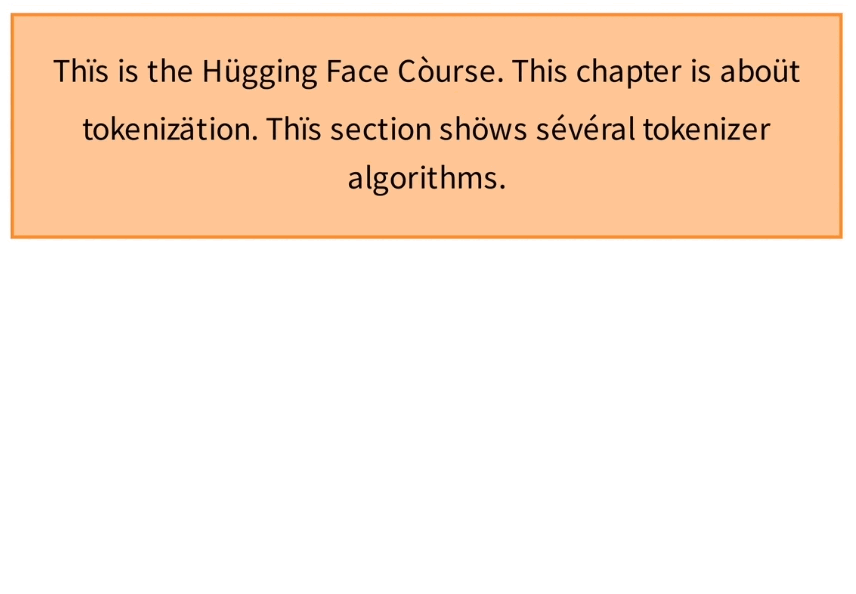

Shown below is the vocabulary building process from the symbols the construct the pre-tokenized words. This is followed by the computation of the symbol-pair frequencies to identify the most common pair and merge it as a single token.

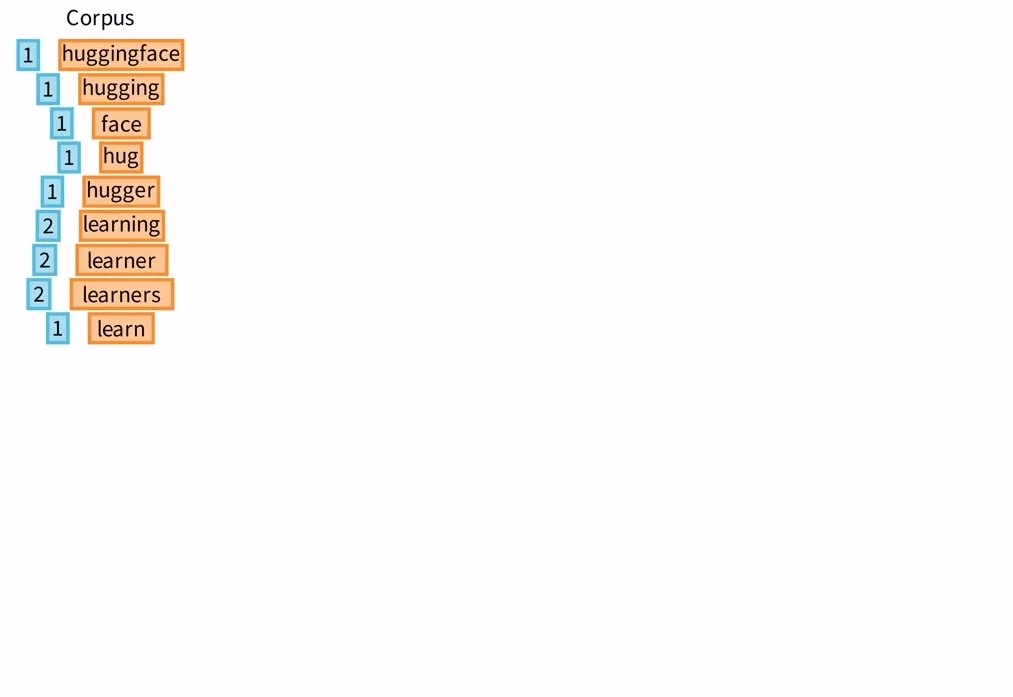

## WordPiece Model

WordPiece is the tokenization algorithm Google developed to pretrain BERT. It has since been reused in quite a few Transformer models based on BERT, such as DistilBERT. It’s very similar to BPE in terms of the training, but the actual tokenization is done differently.


### WordPiece Model Training

The wordpiece model is generated using a data-driven approach to maximize the language-model likelihood of the training data, given an evolving word definition. Given a training corpus and a number of desired tokens $D$, the optimization problem is to select $D$ wordpieces such that the resulting corpus is minimal in the number of wordpieces when segmented according to the chosen wordpiece model.

Like BPE, WordPiece starts from a small vocabulary including the special tokens used by the model and the initial alphabet. Since it identifies subwords by adding a prefix (like ## for BERT), each word is initially split by adding that prefix to all the characters inside the word. So, for instance, `word` gets split like this: `w` `##o` `##r` `##d`. Thus, the initial alphabet contains all the characters present at the beginning of a word and the characters present inside a word preceded by the WordPiece prefix.

Then, again like BPE, WordPiece learns merge rules. The main difference is the way the pair to be merged is selected. Instead of selecting the most frequent pair, WordPiece computes a score for each pair, using the following formula:

$score = \frac{freq(pair)}{freq(first\_element) \times freq(second\_element)}$

By dividing the frequency of the pair by the product of the frequencies of each of its parts, the algorithm prioritizes the merging of pairs where the individual parts are less frequent in the vocabulary. For instance, it won’t necessarily merge (`un`, `##able`) even if that pair occurs very frequently in the vocabulary, because the two pairs `un` and `##able` will likely each appear in a lot of other words and have a high frequency. In contrast, a pair like (`hu`, `##gging`) will probably be merged faster (assuming the word “hugging” appears often in the vocabulary) since `hu` and `##gging` are likely to be less frequent individually.

**Example:-**

Considering the same example of BPE, assuming the unique words in the corpus are: 

(`hug`, 10), (`pug`, 5), (`pun`, 12), (`bun`, 4), (`hugs`, 5), 

which is split into the following tokens: 

(`h` `##u` `##g`, 10), (`p` `##u` `##g`, 5), (`p` `##u` `##n`, 12), (`b` `##u` `##n`, 4), (`h` `##u` `##g` `##s`, 5).

Thus, the initial vocabulary and corpus will be: 

<font color="hotpink">Vocabulary</font>: [`b`, `h`, `p`, `##g`, `##n`, `##s`, `##u`] 

<font color="hotpink">Corpus</font>: (`h` `##u` `##g`, 10), (`p` `##u` `##g`, 5), (`p` `##u` `##n`, 12), (`b` `##u` `##n`, 4), (`h` `##u` `##g` `##s`, 5)

The most frequent pair is (`##u`, `##g`) (present 20 times), but the individual frequency of `##u` is very high, so its score $(1 / 36)$ is not the highest. All pairs with a `##u` actually have that same score $(1 / 36)$, so the best score goes to the pair (`##g`, `##s`) at $1 / 20$, and the first merge learned is (`##g`, `##s`) $→$ (`##gs`).

The vocabulary and corpus are updated as follows:

<font color="hotpink">Vocabulary</font>: [`b`, `h`, `p`, `##g`, `##n`, `##s`, `##u`, `##gs`]

<font color="hotpink">Corpus</font>: (`h` `##u` `##g`, 10), (`p` `##u` `##g`, 5), (`p` `##u` `##n`, 12), (`b` `##u` `##n`, 4), (`h` `##u` `##gs`, 5)

and we continue like this until we reach the desired vocabulary size.

Shown below is an animation of the WordPiece algorithm training process:

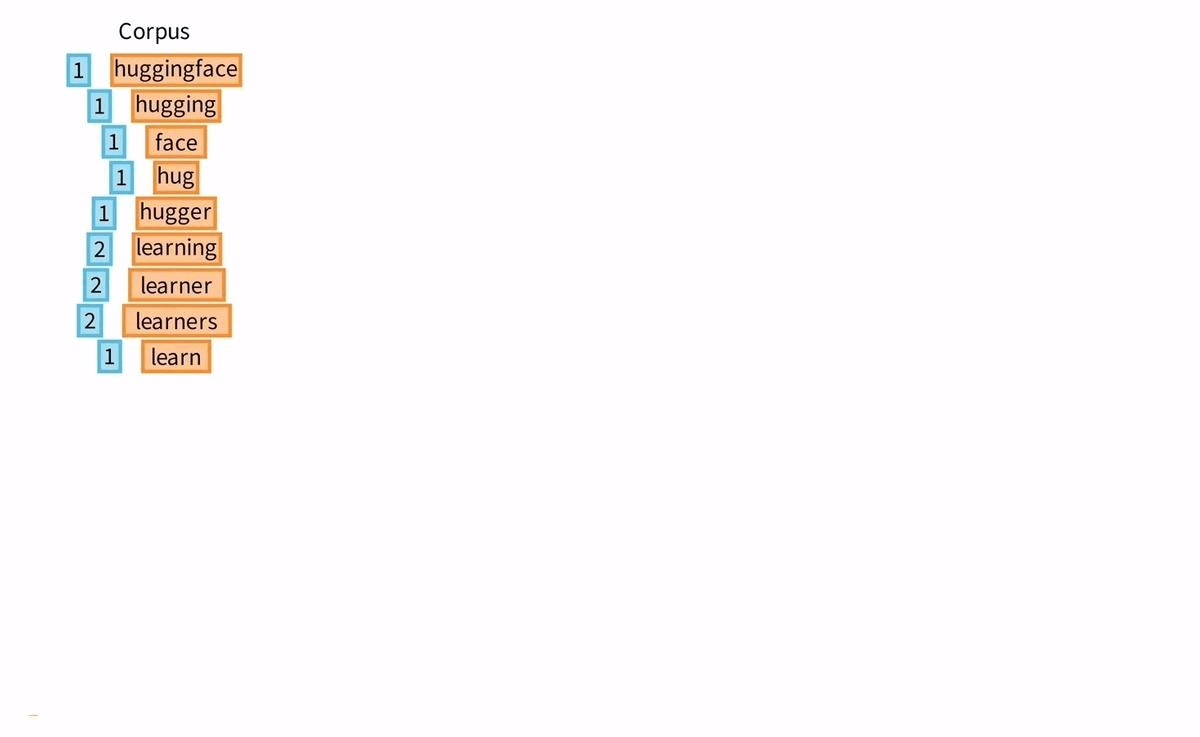

## 🤗Hugging Face Pre-trained BERT WordPiece Tokenizer

🤗 Tokenizers provides an implementation of today’s most used tokenizers, with a focus on performance and versatility. These are fast State-of-the-art tokenizers, optimized for both research and production.

### Setup

In [1]:
!pip install transformers -q

     |████████████████████████████████| 4.9 MB 14.1 MB/s 
     |████████████████████████████████| 6.6 MB 61.9 MB/s 
     |████████████████████████████████| 163 kB 87.4 MB/s 


### Imports

In [3]:
from transformers import AutoTokenizer

### Instanciating a Pre-trained BERT WordPiece Tokenizer

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

### Text Tokenization

In [18]:
tokens_ids = tokenizer.encode("Testing BERT's tokenizer from hugging face library.")
print(f"Tokens IDs: {tokens_ids}")

decoded_ids = tokenizer.convert_ids_to_tokens(tokens_ids)
print(f"Decoded IDs: {decoded_ids}")

Tokens IDs: [101, 27259, 139, 9637, 1942, 112, 188, 22559, 17260, 1121, 19558, 1339, 3340, 119, 102]
Decoded IDs: ['[CLS]', 'Testing', 'B', '##ER', '##T', "'", 's', 'token', '##izer', 'from', 'hugging', 'face', 'library', '.', '[SEP]']


## References

1. WordPiece Paper: [Google's Neural Machine Translation System: Bridging the Gap between Human and Machine Translation](https://arxiv.org/abs/1609.08144)

2. Byte-Pair Encoding Paper: [Neural Machine Translation of Rare Words with Subword Units](https://arxiv.org/abs/1508.07909)

3. 🤗Hugging Face Documentation: [Byte-Pair Encoding](https://huggingface.co/course/chapter6/5?fw=pt), [WordPiece](https://huggingface.co/course/chapter6/6?fw=pt)